# **Install, Import Modules, & Configuration**

Kode ini digunakan untuk menyiapkan lingkungan kerja dalam melakukan analisis data dan pemodelan machine learning untuk kasus klasifikasi, seperti prediksi stroke. Berbagai pustaka seperti `pandas`, `numpy`, `matplotlib`, dan `seaborn` digunakan untuk manipulasi data dan visualisasi, sementara `scipy` dimanfaatkan untuk analisis statistik. Penanganan data hilang dilakukan dengan `KNNImputer`, dan beberapa algoritma klasifikasi seperti `CatBoost`, `XGBoost`, `LightGBM`, `RandomForest`, dan `DecisionTree` disiapkan untuk membangun model. Evaluasi model dilakukan menggunakan metrik seperti akurasi, precision, recall, f1-score, dan AUC. Selain itu, `optuna` digunakan untuk hyperparameter tuning, dan pengaturan visual dilakukan untuk menghasilkan output grafik yang lebih rapi dan informatif.


In [1]:
!pip install optuna catboost -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import kagglehub
import os
import optuna

from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
)
from scipy.stats.mstats import winsorize
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# **Download Dataset**

Proses pengunduhan dataset dari Kaggle menggunakan kagglehub dan menampilkan lokasi penyimpanan file yang telah diunduh. Fungsi kagglehub.dataset_download() mengambil dataset dari repositori "fedesoriano/stroke-prediction-dataset", lalu menyimpan path-nya ke dalam variabel path.

In [4]:
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stroke-prediction-dataset


# **Load Dataset**

Proses memuat dataset yang telah diunduh ke dalam bentuk DataFrame. File CSV diakses dengan menggabungkan path folder unduhan dan nama file menggunakan `os.path.join`. Setelah dataset dibaca dengan `pandas.read_csv`, dilakukan eksplorasi awal menggunakan `describe()` untuk melihat statistik ringkas dari fitur numerik, serta `info()` untuk menampilkan struktur data, tipe setiap kolom, dan jumlah nilai yang tidak null pada masing-masing kolom. Langkah ini penting untuk memahami kondisi awal data sebelum dilakukan pembersihan dan pemrosesan lebih lanjut.

In [5]:
full_path = os.path.join(path, "healthcare-dataset-stroke-data.csv")
df = pd.read_csv(full_path)

In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# **Exploratory Data Analysis**

## Correlation

Membuat heatmap korelasi untuk melihat hubungan linier antar fitur numerik dalam dataset. Data yang bertipe objek dikeluarkan, dan kolom 'id' dihapus sebelum perhitungan korelasi dilakukan. Hasil korelasi divisualisasikan dalam bentuk heatmap menggunakan `seaborn`, dengan anotasi nilai korelasi dan skema warna 'coolwarm'. Visualisasi ini membantu mengidentifikasi fitur yang memiliki korelasi tinggi, baik positif maupun negatif, yang dapat berpengaruh dalam proses pemodelan selanjutnya.


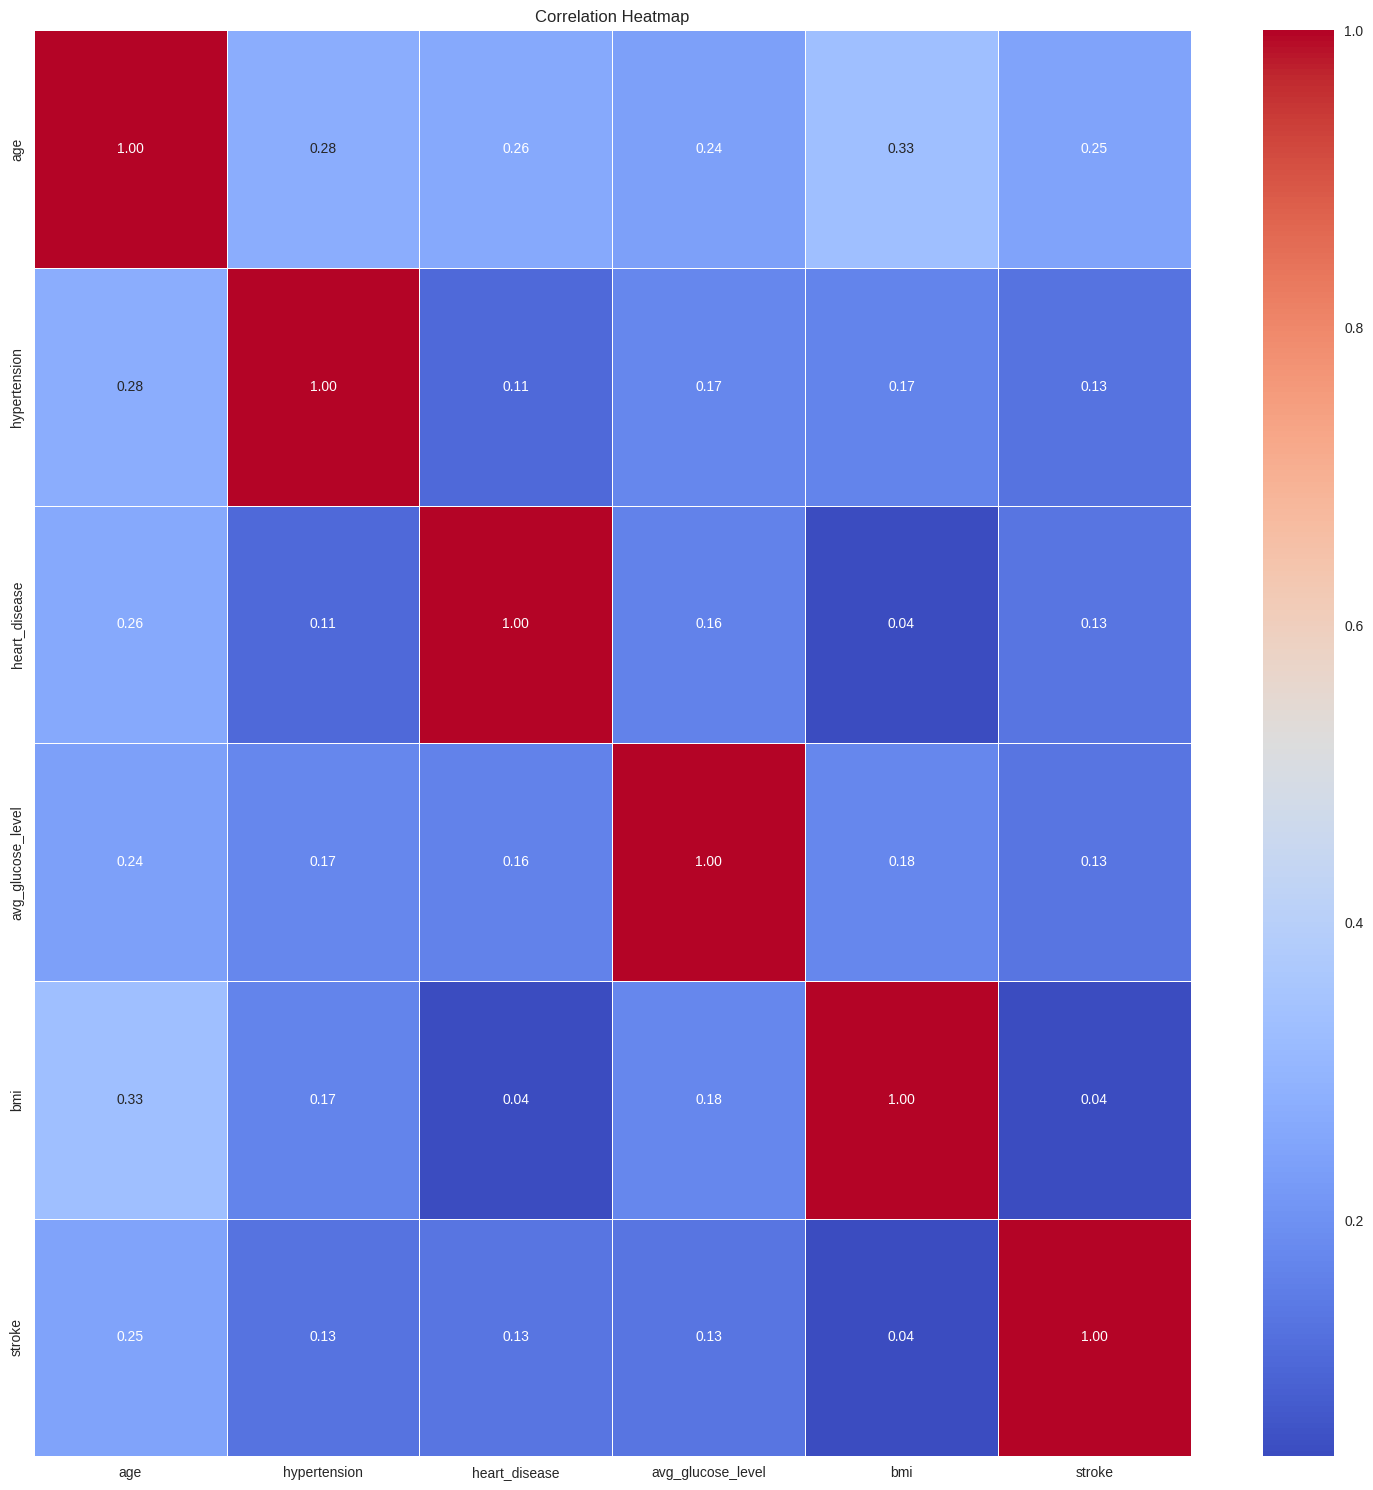

In [8]:
data_corr = df.select_dtypes(exclude='object').drop(columns='id').corr()

plt.figure(figsize=(15, 15))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

**Interpretasi**

Heatmap korelasi tersebut menunjukkan bahwa tidak ada fitur numerik yang memiliki korelasi tinggi terhadap risiko stroke, namun beberapa fitur menunjukkan hubungan positif meskipun lemah. Variabel age memiliki korelasi tertinggi dengan stroke (0.25), diikuti oleh hypertension, heart_disease, dan avg_glucose_level yang masing-masing memiliki korelasi sekitar 0.13. Sementara itu, bmi menunjukkan korelasi yang sangat rendah (0.04), menandakan hubungan linier yang nyaris tidak ada. Korelasi antar fitur juga tergolong rendah, dengan yang tertinggi adalah antara age dan bmi (0.33), sehingga tidak ditemukan masalah multikolinearitas.

## Data Distribution

Melakukan visualisasi histogram untuk melihat distribusi data dari setiap fitur numerik dalam dataset. Setiap kolom ditampilkan dalam bentuk histogram terpisah, sehingga pola distribusi seperti skewness, outlier, atau dominasi nilai tertentu dapat dikenali dengan lebih mudah. Ukuran figure diperbesar agar semua plot terlihat jelas, dan tata letak diatur secara otomatis untuk menghindari tumpang tindih antar grafik.

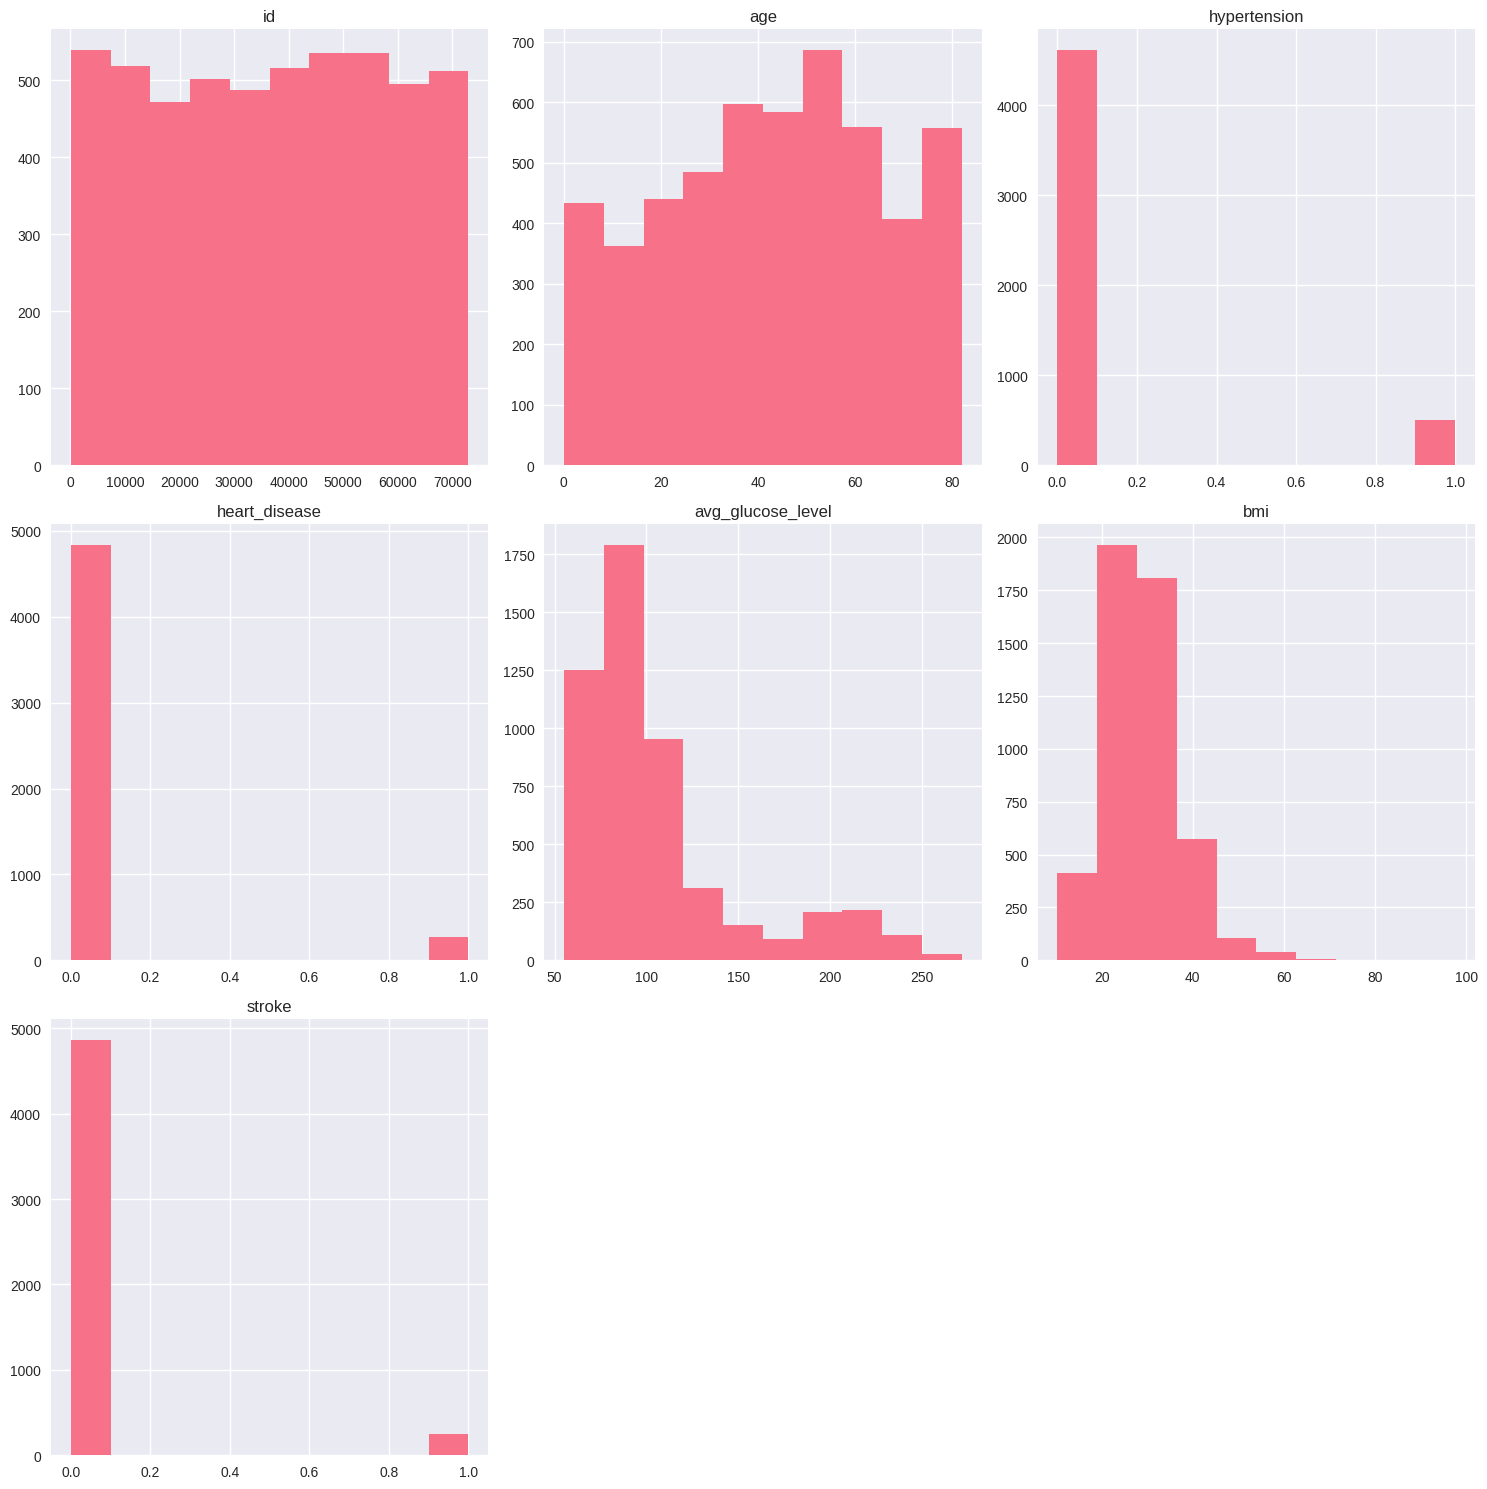

In [9]:
df.hist(figsize=(15, 15))
plt.tight_layout()
plt.show()

**Interpretasi**

Berdasarkan hasil eksplorasi data numerik, sebagian besar fitur memiliki distribusi yang tidak seimbang. Fitur age terdistribusi relatif normal dengan mayoritas di usia 40–60 tahun, namun terdapat nilai ekstrem seperti 0.08 yang perlu diverifikasi. Fitur avg_glucose_level dan bmi menunjukkan distribusi miring ke kanan (right-skewed) dengan beberapa outlier ekstrem, sehingga transformasi log atau scaling dapat dipertimbangkan. Rata-rata BMI (28.89) menunjukkan populasi cenderung overweight, dan terdapat 201 nilai kosong pada fitur ini yang perlu ditangani. Fitur biner seperti hypertension dan heart_disease didominasi oleh nilai nol (tidak memiliki kondisi tersebut), sementara label target stroke juga sangat tidak seimbang (hanya sekitar 4.9% kasus positif), sehingga perlu penanganan class imbalance saat membangun model prediksi.

## Outliers Detection

Langkah ini digunakan untuk mendeteksi dan memvisualisasikan outlier pada fitur numerik dalam dataset (kecuali `id`, `hypertension`, `heart_disease`, dan `stroke` yang dianggap kategorikal). Proses dimulai dengan menghitung batas bawah dan atas menggunakan metode Interquartile Range (IQR). Data yang berada di luar rentang ini dianggap sebagai outlier. Jumlah dan persentase outlier dari masing-masing fitur disimpan ke dalam ringkasan. Selanjutnya, boxplot dibuat untuk empat fitur pertama guna memperlihatkan distribusi nilai serta keberadaan outlier secara visual. Visualisasi ini membantu dalam pengambilan keputusan apakah outlier perlu ditangani lebih lanjut pada tahap pra-pemrosesan.

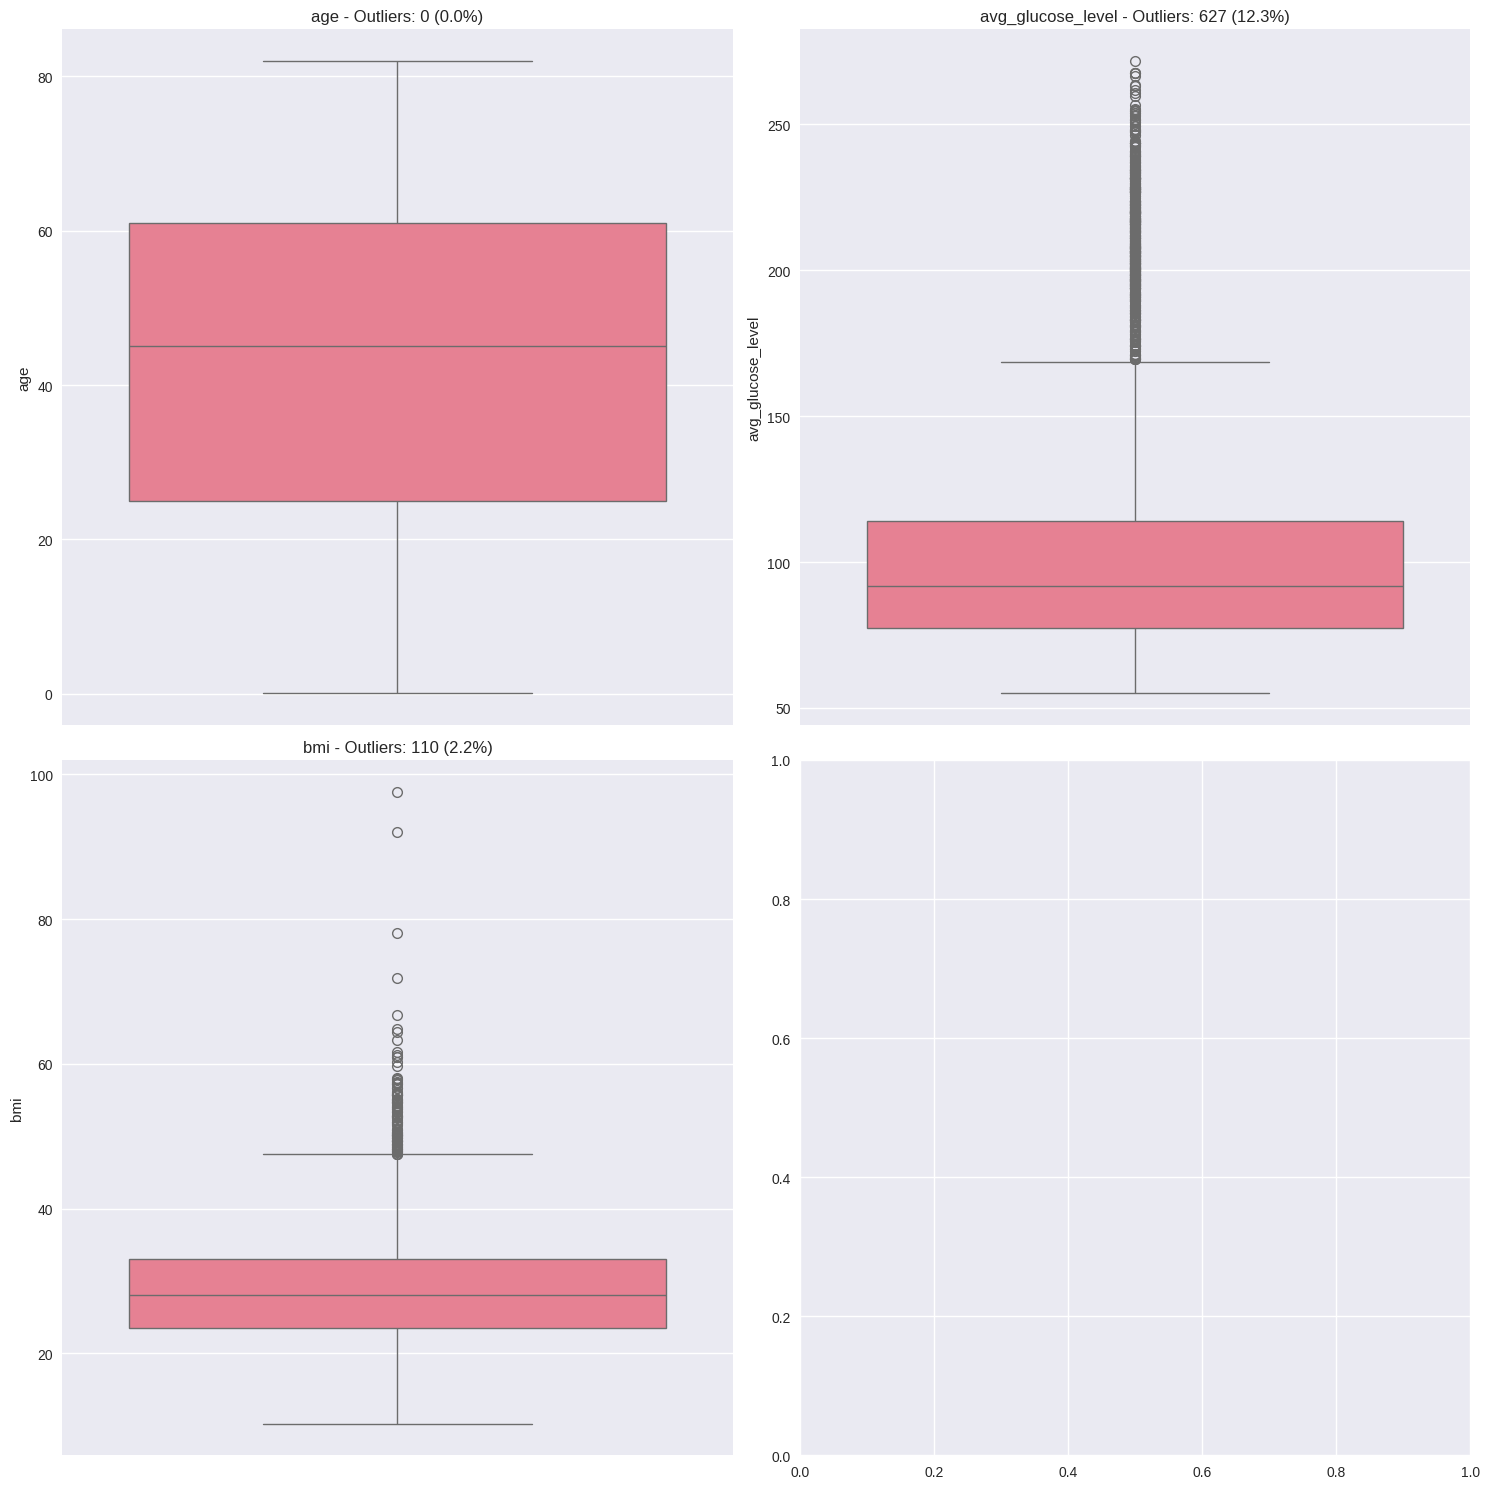

In [10]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['id', 'hypertension', 'heart_disease', 'stroke']] # Tidak mengambil yang kategorikal

outlier_summary = []

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for i, col in enumerate(numerical_cols[:4]):
    if i < len(axes):

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100

        outlier_summary.append({
                'Column': col,
                'Outlier_Count': outlier_count,
                'Outlier_Percentage': f"{outlier_percentage:.2f}%",
                'Lower_Bound': f"{lower_bound:.2f}",
                'Upper_Bound': f"{upper_bound:.2f}"
            })

        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'{col} - Outliers: {outlier_count} ({outlier_percentage:.1f}%)')

plt.tight_layout()
plt.show()

**Interpretasi**

Fitur age tidak memiliki outlier, namun tetap mengandung nilai sangat rendah mendekati nol yang perlu divalidasi kebenarannya. Fitur avg_glucose_level mengandung outlier cukup banyak yaitu 627 data (12.3%), dengan nilai yang jauh lebih tinggi dari rentang interkuartil, menunjukkan distribusi yang sangat skewed. Fitur bmi juga memiliki 110 outlier (2.2%), meskipun skalanya tidak se-ekstrem avg_glucose_level. Keberadaan outlier pada kedua fitur ini dapat mempengaruhi kinerja model prediktif, sehingga perlu dipertimbangkan apakah akan ditangani melalui metode winsorizing, transformasi log, atau penghapusan langsung. Sementara itu, plot terakhir kosong karena tidak ada fitur numerik keempat yang ditampilkan. Secara keseluruhan, penanganan outlier menjadi salah satu langkah penting dalam preprocessing data ini.

## Target Column Class Distribution

Manampilkan distribusi target untuk memberikan gambaran tentang proporsi kasus stroke dan non-stroke dalam dataset. Visualisasi menggunakan dua jenis grafik: bar chart untuk menunjukkan jumlah absolut masing-masing kelas, dan pie chart untuk memperlihatkan persentase relatif. Warna yang kontras digunakan untuk membedakan kedua kategori, dan penambahan label serta judul membantu memperjelas interpretasi. Dari visualisasi ini, ketidakseimbangan kelas dapat langsung dikenali, yang penting untuk dipertimbangkan dalam proses pemodelan dan evaluasi.

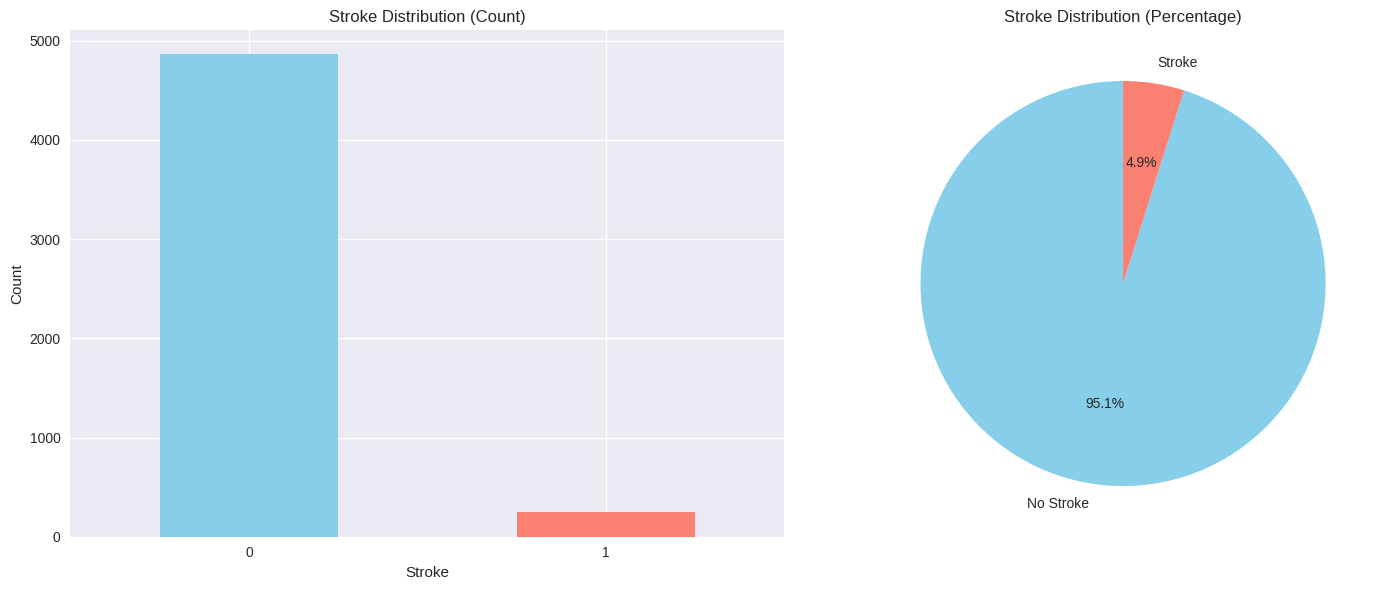

In [11]:
target_counts = df['stroke'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

target_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Stroke Distribution (Count)')
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

axes[1].pie(target_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%',
                colors=['skyblue', 'salmon'], startangle=90)
axes[1].set_title('Stroke Distribution (Percentage)')

plt.tight_layout()
plt.show()

**Interpretasi**

Sebagian besar data (sekitar 95.1%) berasal dari individu yang tidak mengalami stroke, sementara hanya 4.9% data berasal dari individu yang mengalami stroke. Ketidakseimbangan ini menunjukkan bahwa dataset bersifat imbalanced, yang dapat menyebabkan model machine learning cenderung bias terhadap kelas mayoritas. Oleh karena itu, perlu dipertimbangkan penanganan khusus seperti resampling (oversampling kelas minoritas atau undersampling kelas mayoritas), penggunaan algoritma yang robust terhadap ketidakseimbangan kelas, atau penerapan class weight adjustment untuk menghasilkan model yang lebih adil dan akurat dalam mendeteksi kasus stroke.

## Plot Categorical Variables vs Target Variable

Visualisasi ini digunakan untuk mengeksplorasi hubungan antara fitur kategorikal dan target `stroke`. Setiap fitur kategorikal dianalisis menggunakan cross-tabulation yang dinormalisasi berdasarkan baris, sehingga menunjukkan persentase kasus stroke dan non-stroke dalam setiap kategori. Hasilnya divisualisasikan sebagai stacked bar chart untuk memudahkan perbandingan antar kategori. Tampilan persentase ini membantu mengidentifikasi pola atau kecenderungan tertentu pada kelompok-kelompok data, yang bisa berguna dalam pemahaman awal data dan seleksi fitur untuk model.


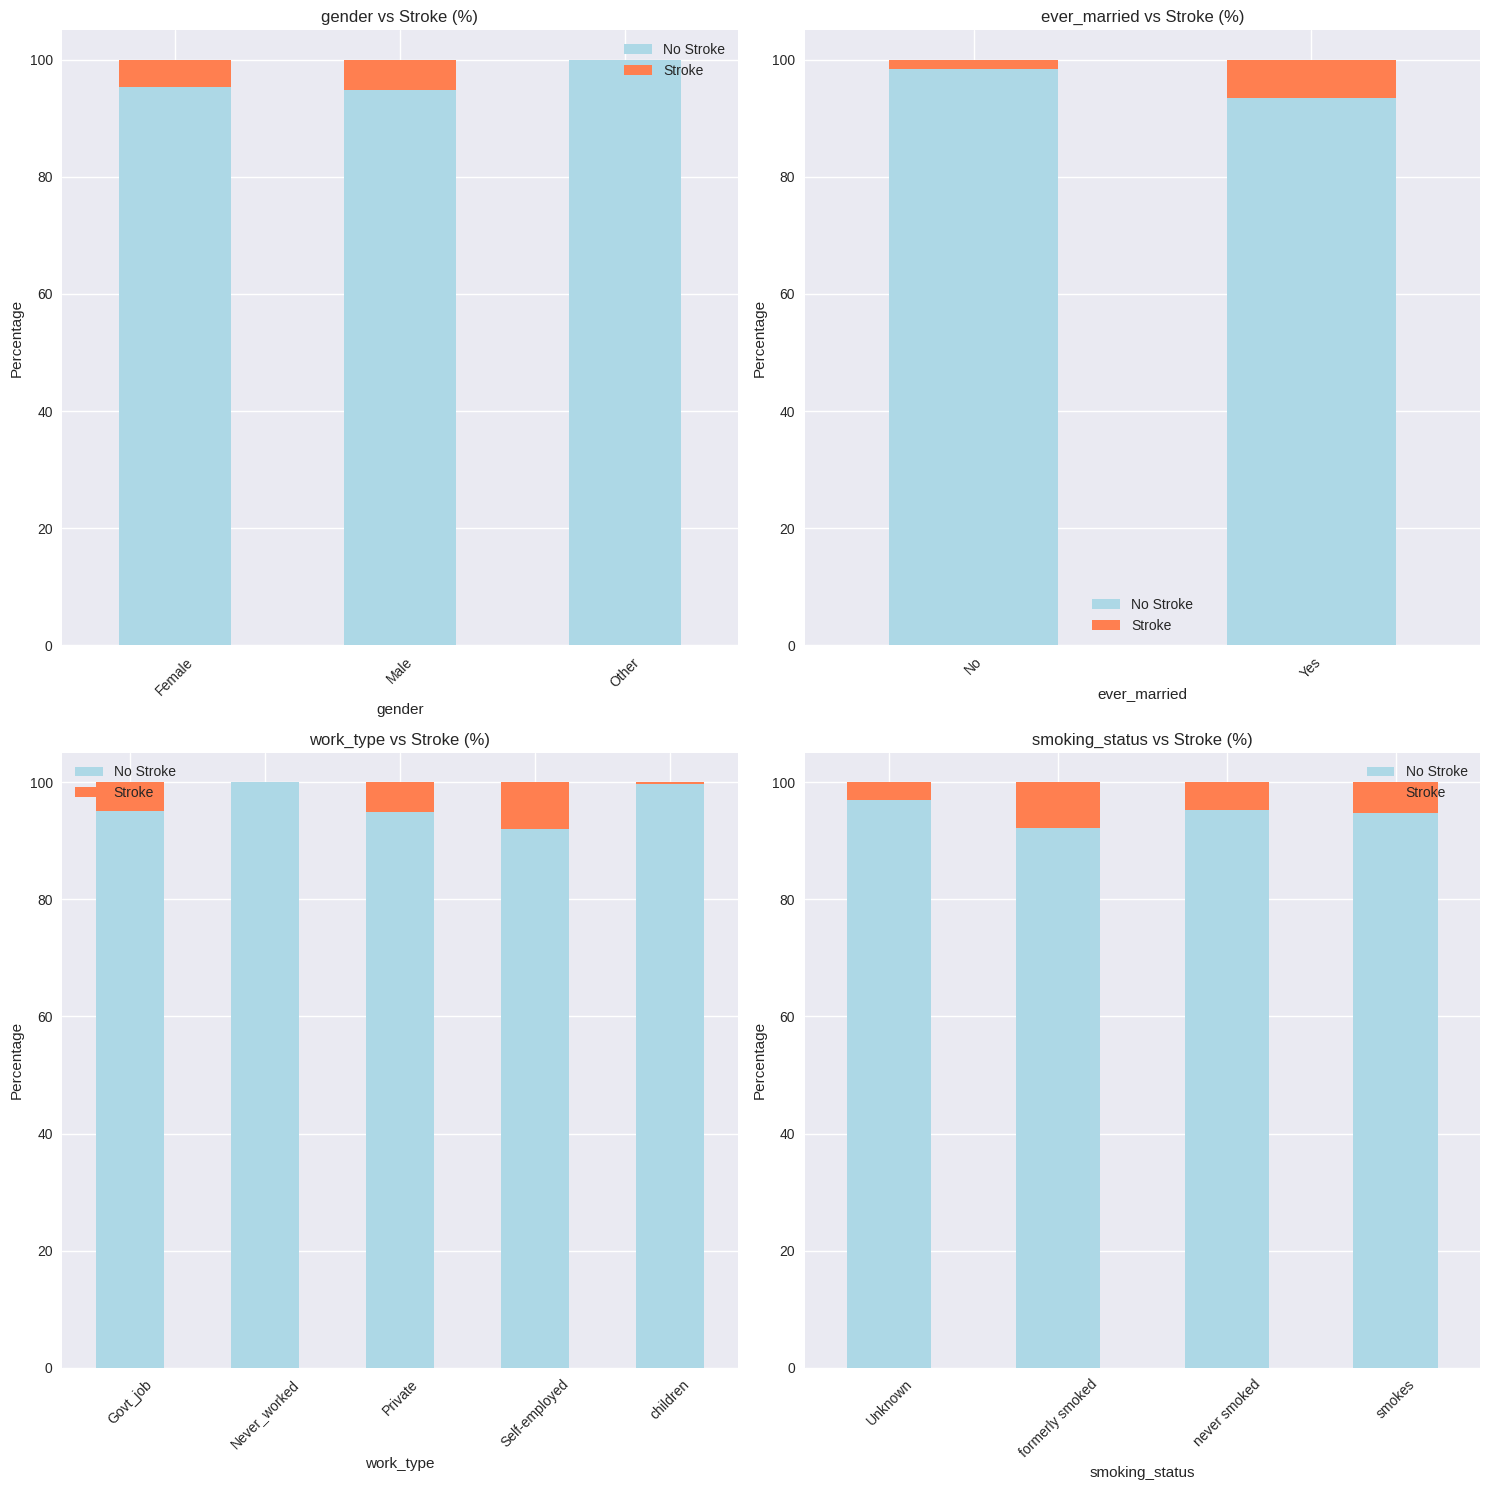

In [12]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if 'id' not in col.lower()]

n_cols = len(categorical_cols)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_cols[:4]):
    if i < len(axes):
       ct = pd.crosstab(df[col], df["stroke"], normalize='index') * 100
       ct.plot(kind='bar', ax=axes[i], stacked=True, color=['lightblue', 'coral'])
       axes[i].set_title(f'{col} vs Stroke (%)')
       axes[i].set_xlabel(col)
       axes[i].set_ylabel('Percentage')
       axes[i].legend(['No Stroke', 'Stroke'])
       axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Interpretasi**

Terlihat bahwa proporsi penderita stroke sedikit lebih tinggi pada individu yang pernah menikah dibandingkan yang belum menikah. Pada variabel jenis kelamin, baik pria maupun wanita memiliki proporsi stroke yang hampir serupa, sementara kategori "Other" terlalu sedikit untuk dianalisis secara representatif. Terkait jenis pekerjaan, kelompok self-employed dan private menunjukkan persentase stroke yang lebih tinggi dibanding kelompok lain. Pada fitur smoking status, individu yang merokok atau pernah merokok memiliki persentase stroke yang lebih tinggi dibandingkan yang tidak merokok atau status merokoknya tidak diketahui. Temuan ini menunjukkan adanya perbedaan risiko stroke berdasarkan faktor gaya hidup dan status sosial-demografis tertentu, yang penting untuk diperhatikan dalam analisis prediktif lebih lanjut.

##Pairplot Numeric Feature

Membuat visualisasi *pairplot* dari tiga fitur numerik penting dalam dataset (`age`, `avg_glucose_level`, dan `bmi`) dengan membedakan kelas berdasarkan variabel target `stroke`. Visualisasi ini menampilkan hubungan antar fitur melalui scatter plot dan distribusi setiap fitur menggunakan estimasi kepadatan (KDE) pada diagonalnya, dengan titik data yang diwarnai menurut apakah pasien mengalami stroke atau tidak. Selain itu, kode mengatur ukuran gambar, memberi judul utama, memperbaiki label dan posisi legenda agar lebih informatif dan mudah dibaca, serta memastikan tata letak plot rapi tanpa tumpang tindih sebelum menampilkan hasilnya. Tujuannya adalah untuk membantu eksplorasi data dan memahami pola serta perbedaan fitur antara kelompok pasien stroke dan non-stroke.


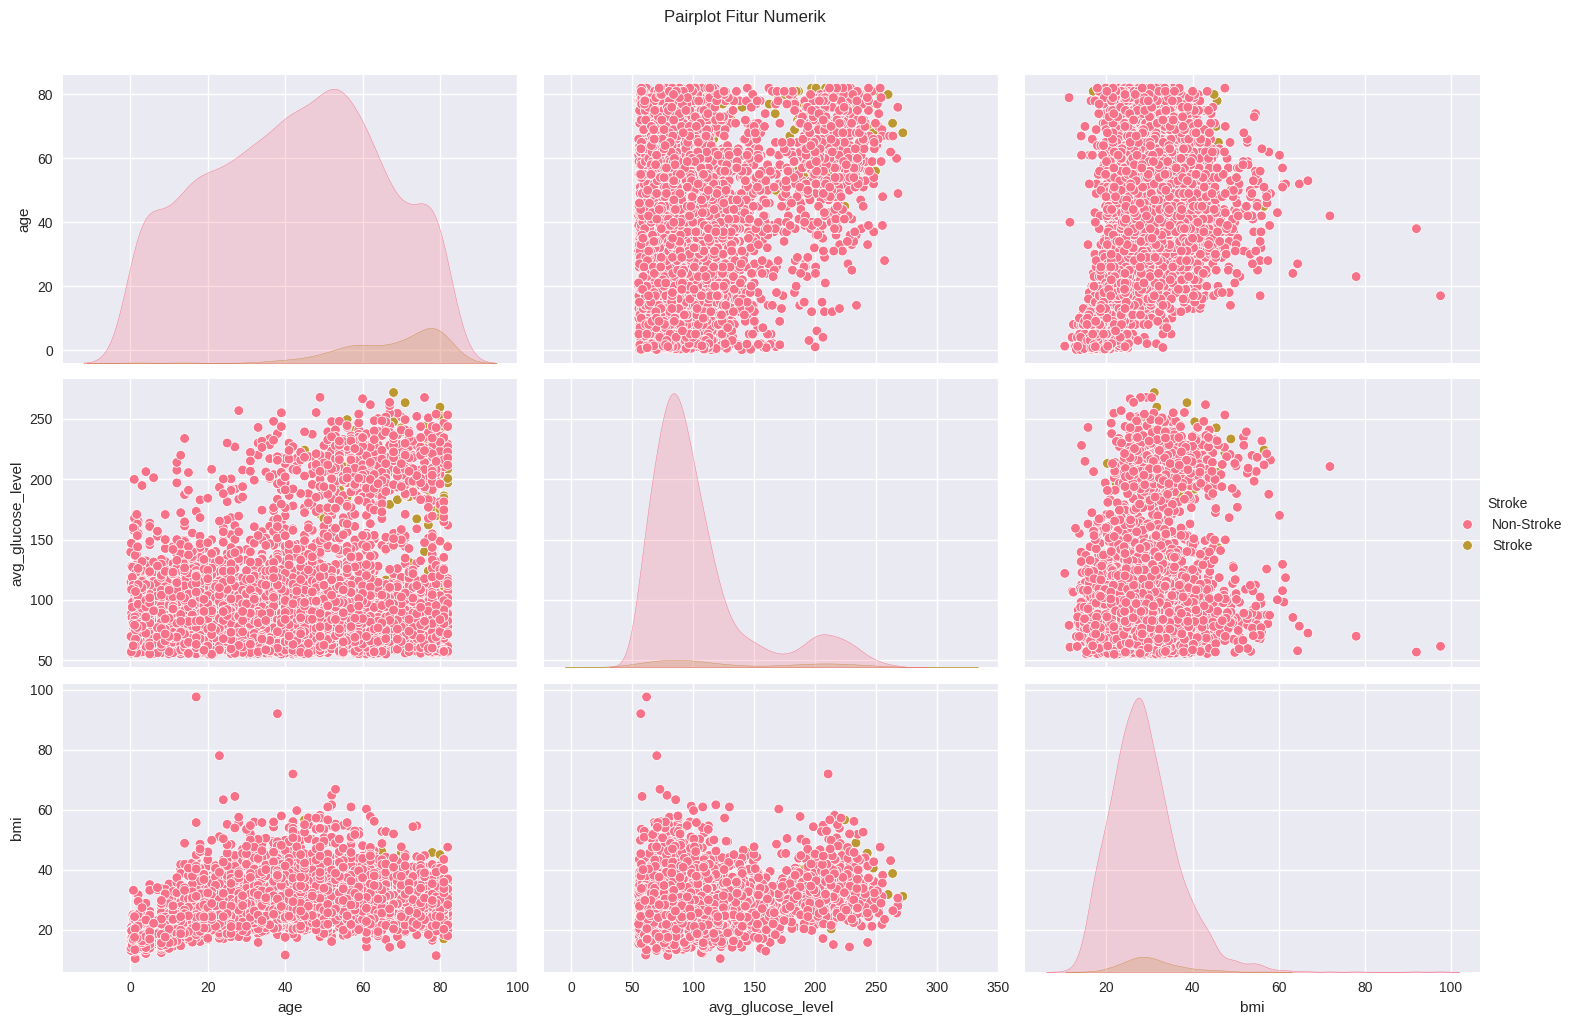

In [13]:
selected_cols = ['age', 'avg_glucose_level', 'bmi', 'stroke']

g = sns.pairplot(df[selected_cols], hue='stroke', diag_kind='kde')

g.fig.set_size_inches(15, 10)
g.fig.suptitle("Pairplot Fitur Numerik", y=1.02)

g._legend.set_title("Stroke")
for t, l in zip(g._legend.texts, ['Non-Stroke', 'Stroke']):
    t.set_text(l)

for text in g._legend.texts:
    text.set_fontsize(10)

g._legend.set_bbox_to_anchor((1.05, 0.5))

plt.tight_layout()
plt.show()

**Interpretasi**

- Usia (age): Hampir semua kasus stroke terjadi pada individu berusia di atas 50 tahun, dengan konsentrasi tertinggi antara 60–80 tahun. Hal ini menunjukkan bahwa risiko stroke meningkat signifikan seiring bertambahnya usia.

- Tingkat Glukosa Rata-rata (avg_glucose_level): Penderita stroke cenderung memiliki kadar glukosa darah yang lebih tinggi, sebagian besar di atas 150. Ini mendukung hipotesis bahwa kadar gula darah tinggi (misalnya akibat diabetes) merupakan faktor risiko stroke.

- BMI (bmi): Tidak terlihat pola yang sangat jelas antara BMI dan stroke, namun sebagian besar penderita stroke berada dalam rentang BMI 25–40, yang termasuk kategori overweight hingga obesitas. Hal ini menunjukkan bahwa kelebihan berat badan bisa menjadi salah satu faktor pendukung, meskipun tidak sekuat usia dan kadar glukosa.

# **Data Preparation**

Mengkopi dataframe utama agar perubahan yang dilakukan selama proses data preparation tidak mengubab apapun pada dataset original

In [14]:
df_prep = df.copy()

## Drop Kolom yang Tidak Relevan (ID, Duplikat)

Membersihkan data pada DataFrame df_prep dengan dua langkah utama: pertama, menghapus kolom id yang biasanya berisi identifier unik dan tidak diperlukan dalam analisis atau pemodelan, dan kedua, menghilangkan baris-baris duplikat agar dataset hanya berisi data yang unik dan tidak ada pengulangan yang dapat memengaruhi hasil analisis atau pelatihan model.

In [15]:
df_prep = df_prep.drop(columns=['id'])
df_prep = df_prep.drop_duplicates()

## Encoding Variabel Kategorikal

Mengubah fitur kategorikal pada DataFrame `df_prep` menjadi representasi numerik agar dapat digunakan dalam pemodelan machine learning, dengan cara mengonversi kolom `gender` menjadi 0 untuk 'Male', 1 untuk 'Female', dan 2 untuk lainnya; kolom `ever_married` menjadi 0 untuk 'Yes' dan 1 untuk 'No'; serta kolom `Residence_type` menjadi 0 untuk 'Urban' dan 1 untuk tipe lain. Selanjutnya, kolom `smoking_status` dipetakan ke nilai numerik berdasarkan kamus khusus, dan kolom `work_type` diubah menjadi variabel dummy menggunakan one-hot encoding dengan menghilangkan satu kategori dasar untuk menghindari multikolinearitas, sehingga semua fitur kategorikal siap digunakan dalam analisis atau pelatihan model.

In [16]:
df_prep['gender'] = df_prep['gender'].apply(lambda x: 0 if x == 'Male' else 1 if x == "Female" else 2)
df_prep['ever_married'] = df_prep['ever_married'].apply(lambda x: 0 if x == 'Yes' else 1)
df_prep['Residence_type'] = df_prep['Residence_type'].apply(lambda x: 0 if x == 'Urban' else 1)

smoke_mapping = {
    'never smoked': 0,
    'formerly smoked': 1,
    'smokes': 2,
    'Unknown': 3
}
df_prep['smoking_status'] = df_prep['smoking_status'].map(smoke_mapping)
df_prep = pd.get_dummies(df_prep, columns=['work_type'], drop_first=True, prefix='work_type', dtype=int)

## Menangani Missing Values

Menggunakan metode imputasi KNN (K-Nearest Neighbors) untuk mengisi nilai yang hilang (missing values) pada DataFrame `df_prep`. Dengan `n_neighbors=5`, algoritma mencari 5 data terdekat berdasarkan fitur lain untuk memperkirakan nilai yang hilang, kemudian hasil imputasi disimpan dalam array `bmi_imputed`. Selanjutnya, array tersebut dikonversi kembali menjadi DataFrame dengan kolom yang sama seperti `df_prep`, menghasilkan DataFrame `df_imputed` yang sudah lengkap tanpa missing values, siap untuk analisis atau pemodelan lebih lanjut.


In [32]:
imputer = KNNImputer(n_neighbors=5)
bmi_imputed = imputer.fit_transform(df_prep)
df_imputed = pd.DataFrame(bmi_imputed, columns=df_prep.columns)

## Menangani Outlier

Bagian ini fokus untuk menangangi outlier pada kolom numerik `avg_glucose_level` dan `bmi` di DataFrame `df_imputed` dengan menggunakan metode *winsorizing*. Fungsi `winsorize` membatasi nilai ekstrem di kedua ujung distribusi (5% terendah dan 5% tertinggi atau Q = 0.5 dan Q = 0.95) dengan menggantinya ke batas nilai yang ditetapkan, sehingga mengurangi dampak outlier yang ekstrem tanpa menghapus data. Langkah ini membantu membuat distribusi data lebih stabil dan mencegah outlier merusak hasil analisis atau model.


In [34]:
con_columns = ['avg_glucose_level', 'bmi']
df_imputed[con_columns] = df_imputed[con_columns].apply(lambda x: winsorize(x, (0.05, 0.05)))

## Feature Engineering

Membuat beberapa fitur baru dengan mengelompokkan usia ke dalam kategori, serta menggabungkan atau mengalikan beberapa variabel seperti kadar glukosa, BMI, usia, status merokok, hipertensi, penyakit jantung, jenis kelamin, dan status pekerjaan. Tujuannya adalah untuk menangkap interaksi dan kondisi risiko kesehatan yang mungkin penting untuk analisis atau pemodelan, sehingga data menjadi lebih informatif dan membantu model mengenali pola yang lebih kompleks.

In [19]:
df_imputed['age_group'] = pd.cut(
    df_imputed['age'],
    bins=[0, 30, 50, 100],
    labels=[0, 1, 2]
).astype(int)

df_imputed['glucose_bmi_interaction'] = (
    df_imputed['avg_glucose_level'] * df_imputed['bmi']
)
df_imputed['glucose_per_bmi'] = (
    df_imputed['avg_glucose_level'] / (df_imputed['bmi'] + 1e-3)
)

df_imputed['age_x_smoking'] = (
    df_imputed['age'] * df_imputed['smoking_status']
)

df_imputed['chronic_risk'] = (
    (df_imputed['hypertension'] == 1) &
    (df_imputed['heart_disease'] == 1)
).astype(int)

df_imputed['is_employed'] = (
    df_imputed['work_type_Private'] +
    df_imputed['work_type_Self-employed'] +
    df_imputed['work_type_Never_worked']
)

df_imputed['gender_hyper'] = (
    df_imputed['gender'] * df_imputed['hypertension']
)

## Split Data untuk Pelatihan dan Test

Pemisahan dataset menjadi fitur (`X`) dan target (`y`), di mana kolom `stroke` dipisahkan sebagai label yang ingin diprediksi, sementara sisanya menjadi variabel input. Selanjutnya, data dibagi menjadi data pelatihan (`X_train`, `y_train`) dan data pengujian (`X_test`, `y_test`) dengan proporsi 80% untuk pelatihan dan 20% untuk pengujian. Pembagian ini menggunakan `stratify=y` agar proporsi kelas stroke dan non-stroke tetap terjaga di kedua set, serta `random_state=42` untuk memastikan hasil pembagian dapat direproduksi.

In [20]:
X = df_imputed.drop(columns=['stroke'])
y = df_imputed['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Modeling**

## Model Selection

Kode ini mendefinisikan beberapa model klasifikasi populer—RandomForest, DecisionTree, XGBoost, LightGBM, dan CatBoost—dengan parameter random state untuk reproduksibilitas. Kemudian, menggunakan `StratifiedKFold` dengan 5 fold dan pengacakan, kode melakukan validasi silang (cross-validation) untuk setiap model pada dataset lengkap (`X`, `y`), mengukur performa dengan metrik `f1_macro` yang memperhatikan keseimbangan antar kelas. Skor rata-rata F1 untuk tiap model disimpan dalam dictionary `model_scores_non_umap` dan dicetak. Terakhir, hasil model diurutkan berdasarkan skor tertinggi, sehingga kamu bisa mengetahui model mana yang memiliki performa terbaik menurut F1 macro.


In [21]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Catboost': CatBoostClassifier(verbose=0, random_state=42)
}

skf_non_umap = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_scores_non_umap = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf_non_umap, scoring='f1_macro')
    model_scores_non_umap[name] = np.mean(scores)
    print(f"{name}: F1-weighted Score = {model_scores_non_umap[name]:.4f}")

sorted_models_non_umap = sorted(model_scores_non_umap.items(), key=lambda x: x[1], reverse=True)

RandomForest: F1-weighted Score = 0.4873
DecisionTree: F1-weighted Score = 0.5382
XGBoost: F1-weighted Score = 0.5226
LightGBM: F1-weighted Score = 0.5064
Catboost: F1-weighted Score = 0.5044


## Hyperparamter Tuning pada Model Catboost

Fungsi `objective` ini digunakan untuk mengoptimasi hyperparameter `DecisionTreeClassifier` menggunakan Optuna. Dalam fungsi, beberapa parameter model seperti `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`, dan `max_features` dipilih secara otomatis oleh Optuna dari rentang atau kategori yang telah ditentukan. Model kemudian dilatih menggunakan data pelatihan (`X_train`, `y_train`), dan performanya diukur dengan skor F1 macro pada data uji (`X_test`, `y_test`). Nilai F1 macro ini dikembalikan sebagai metrik yang akan dioptimasi oleh Optuna untuk mencari konfigurasi hyperparameter terbaik.

In [35]:
def objective(trial):
    """
    Fungsi objektif untuk Optuna dengan DecisionTreeClassifier
    """
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'random_state': 42,
    }

    model = DecisionTreeClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')

    return f1

Menjalankan proses *hyperparameter tuning* menggunakan Optuna dengan konfigurasi sebagai berikut: studi diatur untuk **memaksimalkan** skor yang dikembalikan (yaitu F1 macro dari fungsi `objective`), menggunakan algoritma sampling TPE (`TPESampler`) dengan seed 42 agar hasilnya reproducible, serta mengaktifkan *pruner* `MedianPruner` yang akan menghentikan percobaan yang performanya di bawah median dari percobaan sebelumnya untuk menghemat waktu. Proses optimasi dijalankan maksimal untuk 100 percobaan (`n_trials=100`) atau selama satu jam (`timeout=3600 detik`), mana yang tercapai lebih dulu.


In [37]:
study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
    )

study.optimize(objective, n_trials=100, timeout=3600)

[I 2025-05-31 07:49:36,454] A new study created in memory with name: no-name-043d7128-082d-44ed-a9ec-5a90672096ba
[I 2025-05-31 07:49:36,515] Trial 0 finished with value: 0.526646403242148 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.526646403242148.
[I 2025-05-31 07:49:36,570] Trial 1 finished with value: 0.48746238716148443 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 0 with value: 0.526646403242148.
[I 2025-05-31 07:49:36,609] Trial 2 finished with value: 0.48746238716148443 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 0 with value: 0.526646403242148.
[I 2025-05-31 07:49:36,665] Trial 3 finished with value: 0.48746238716148443 and parameters: {'criterion': 'entropy', 'max_de

## Train Final Model

In [38]:
study.best_params

{'criterion': 'entropy',
 'max_depth': 14,
 'min_samples_split': 9,
 'min_samples_leaf': 7,
 'max_features': None}

Melatih model **Decision Tree** menggunakan **hyperparameter terbaik** yang ditemukan oleh Optuna (`study.best_params`). Dengan menyertakan `random_state=42`, hasil pelatihan menjadi konsisten setiap kali dijalankan. Model ini kemudian dilatih pada data latih (`X_train`, `y_train`) dan siap digunakan untuk prediksi atau evaluasi lebih lanjut.


In [25]:
model_dt = DecisionTreeClassifier(**study.best_params, random_state=42)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=7,
                       min_samples_split=9, random_state=42)

# **Evaluasi**

Kode ini menghasilkan prediksi kelas (`y_pred`) dan probabilitas kelas positif (`y_proba`) dari model Decision Tree yang telah dilatih. Prediksi kelas digunakan untuk evaluasi klasifikasi langsung, sementara probabilitas membantu dalam analisis yang lebih sensitif seperti ROC AUC atau penyesuaian threshold.


In [26]:
y_pred = model_dt.predict(X_test)
y_proba = model_dt.predict_proba(X_test)[:, 1]

## Classification Report

Mencetak laporan evaluasi model dalam bentuk classification report, yang berisi metrik seperti precision, recall, f1-score, dan support untuk masing-masing kelas, yaitu Non-Stroke dan Stroke. Laporan ini memberikan gambaran menyeluruh tentang performa model dalam membedakan kedua kelas tersebut.

In [27]:
print(classification_report(y_test, y_pred, target_names=["Non-Stroke", "Stroke"]))

              precision    recall  f1-score   support

  Non-Stroke       0.96      0.98      0.97       972
      Stroke       0.33      0.20      0.25        50

    accuracy                           0.94      1022
   macro avg       0.65      0.59      0.61      1022
weighted avg       0.93      0.94      0.93      1022



Berdasarkan hasil diatas, ditunjukkan bahwa akurasi model yang tinggi sebesar 94%, namun F1 Score Macro hanya 0,61, yang mencerminkan performa rata-rata model pada kedua kelas secara seimbang. Akurasi yang tinggi ini dipengaruhi oleh dominasi kelas Non-Stroke yang jumlahnya jauh lebih banyak, sehingga model cenderung baik dalam mengklasifikasikan kelas mayoritas tetapi kurang efektif mendeteksi kasus Stroke dengan F1 Score rendah (0,25).

## Confusion Matrix

Menampilkan **confusion matrix** dari hasil prediksi model, dengan label kelas “Non-Stroke” dan “Stroke”. Visualisasi ini membantu memahami jumlah prediksi benar dan salah untuk tiap kelas, seperti True Positive, False Positive, True Negative, dan False Negative. Plot ini berguna untuk mengevaluasi kinerja klasifikasi secara visual.


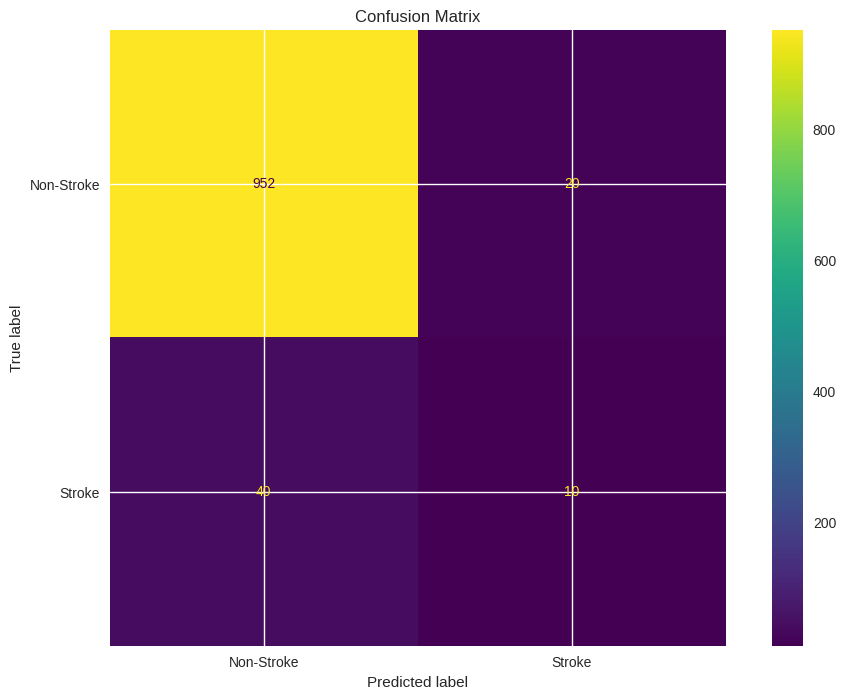

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Non-Stroke", "Stroke"])
plt.title("Confusion Matrix")
plt.show()

Confusion matrix di atas menunjukkan hasil performa model klasifikasi terhadap dua kelas, yaitu Non-Stroke dan Stroke. Dari total data, model berhasil mengklasifikasikan 952 kasus Non-Stroke dengan benar, namun salah mengklasifikasikan 20 kasus Non-Stroke sebagai Stroke. Di sisi lain, hanya 10 kasus Stroke yang berhasil diklasifikasikan dengan benar, sementara 40 kasus Stroke salah diklasifikasikan sebagai Non-Stroke. Hal ini menunjukkan bahwa model memiliki akurasi tinggi dalam mengenali kasus Non-Stroke, tetapi sangat lemah dalam mendeteksi kasus Stroke, yang tercermin dari rendahnya recall untuk kelas Stroke. Kondisi ini berisiko tinggi dalam konteks medis karena dapat menyebabkan banyak kasus stroke yang tidak terdeteksi.


## Kurva ROC

Menampilkan **ROC Curve (Receiver Operating Characteristic)** untuk model Decision Tree dalam tugas klasifikasi stroke. Kurva ini menggambarkan trade-off antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)** pada berbagai threshold klasifikasi. Nilai **AUC (Area Under Curve)** ditampilkan sebagai indikator performa model dalam membedakan kelas; semakin mendekati 1, semakin baik. Garis putus-putus diagonal menunjukkan baseline model acak, dan ROC model ditampilkan sebagai perbandingan visual terhadap baseline tersebut.


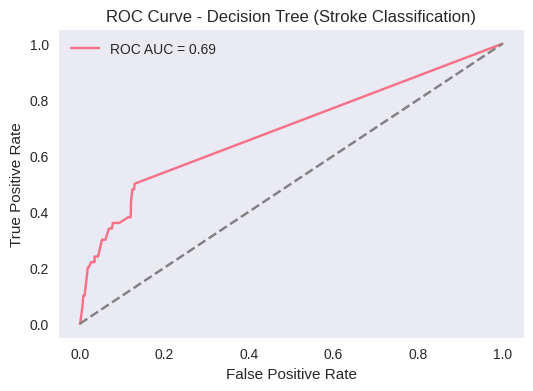

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Stroke Classification)')
plt.legend()
plt.grid()
plt.show()

Kurva ROC untuk model Decision Tree pada klasifikasi stroke ini menunjukkan nilai AUC sebesar 0.69, yang berarti model memiliki kemampuan diskriminatif yang sedang dalam membedakan antara kasus Stroke dan Non-Stroke. Kurva ROC yang sedikit menjauhi garis diagonal (garis abu-abu) menunjukkan bahwa model lebih baik dari sekadar tebakan acak, namun belum cukup kuat untuk diandalkan dalam konteks medis yang kritis. Dari hasil evaluasi ini, diperlukan perbaikan baik dari sisi fitur, data balancing, maupun tuning hyperparameter agar model dapat lebih akurat dalam mendeteksi kasus stroke secara tepat.